### ДЗ 3 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, average_precision_score
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [6]:
def plot_pr_curve(y_test, y_score, beta=1):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+beta**2)*(precision * recall) / (beta**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    lw = 2
    plt.plot(recall, precision, lw=lw, label='PR curve ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve')
    plt.savefig("PR.png")
    plt.show()
    return [precision[ix], recall[ix], thresholds[ix], fscore[ix], average_precision_score(y_test, y_score)]

In [7]:
def plot_roc_curve(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

In [8]:
lr = LogisticRegression(random_state=12)
rf = RandomForestClassifier(random_state=12)
gb = GradientBoostingClassifier(random_state=12)
list_model = [lr, rf, gb]
name_model = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
data = [X_train, y_train, X_test, y_test]

# функция для построения сводной таблицы метрик по разным моделям
def table_metrics(list_model, name_model, data, beta=1):
    X_train, y_train, X_test, y_test = data
    table_metrics = []

    for model, name in zip(list_model, name_model):
        classifier = Pipeline([
            ('features',feats),
            ('classifier', model),
        ])

        #запустим кросс-валидацию
        cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
        cv_score = np.mean(cv_scores)
        cv_score_std = np.std(cv_scores)
        print('CV score in {} is {}+-{}'.format(name, cv_score, cv_score_std))

        #обучим пайплайн на всем тренировочном датасете
        classifier.fit(X_train, y_train)
        y_score = classifier.predict_proba(X_test)[:, 1]
        
        # построим графики
        metrics = plot_pr_curve(y_test, y_score, beta)
        plot_roc_curve(y_test, y_score)
        roc_auc = roc_auc_score(y_test, y_score)
        table_metrics.append([cv_score] + metrics + [roc_auc])
    table_metrics = np.array(table_metrics)
    list_metrics = ['CV-score',  'Precision', 'Recall', 'Best Treshold', 'F-score', 'AUPRC', 'AUROC']
    table = pd.DataFrame(table_metrics, name_model, list_metrics)
    return table
    

CV score in Logistic Regression is 0.7866749255103078+-0.00652621980218306


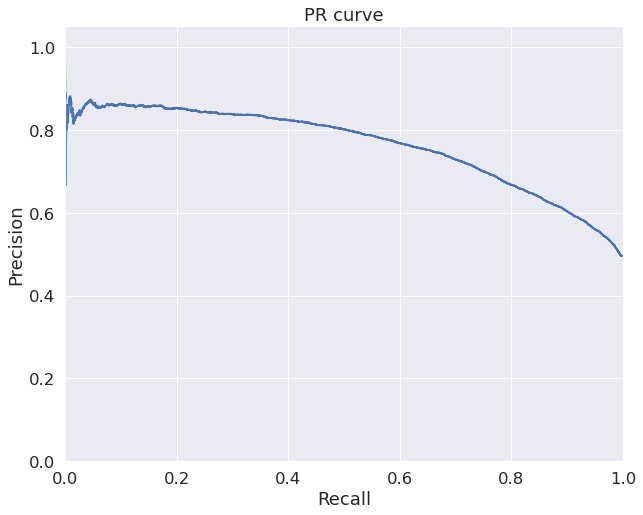

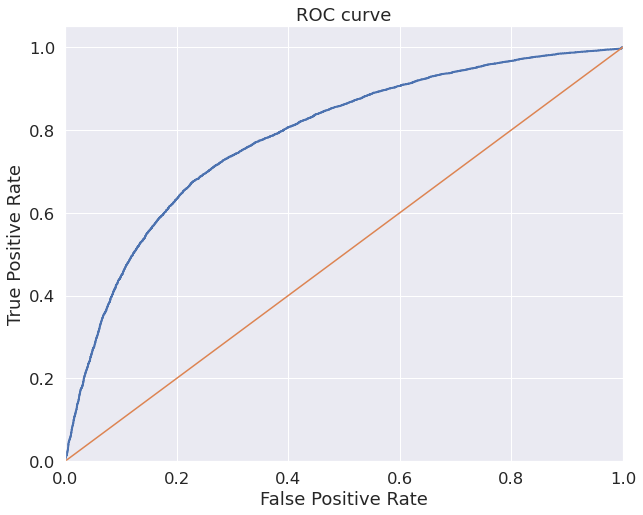

CV score in Random Forest is 0.7740551477887395+-0.00449829629753663


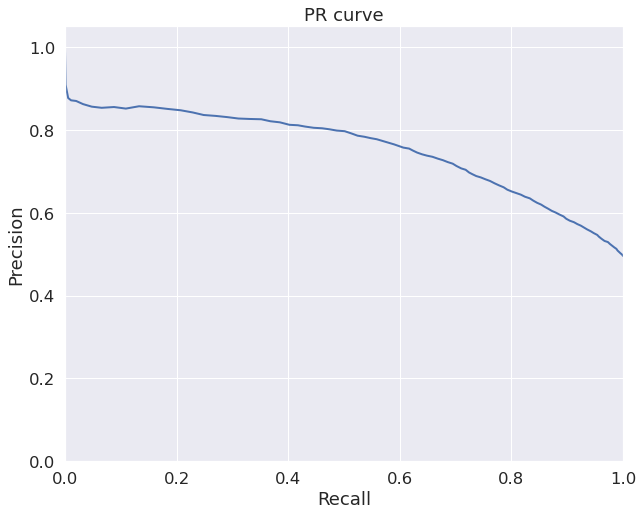

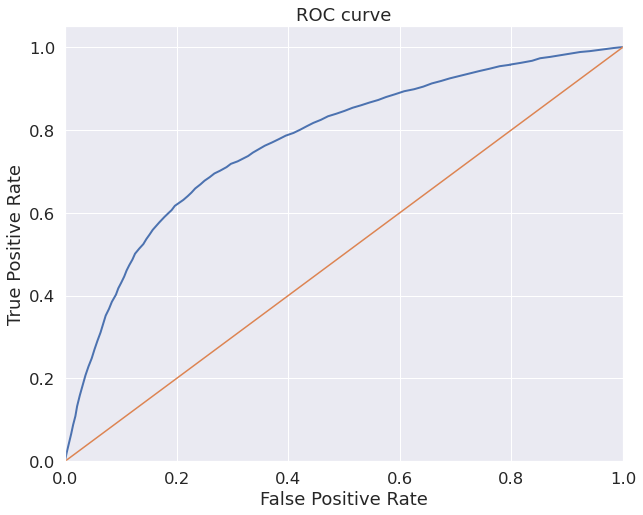

CV score in Gradient Boosting is 0.8023661330884515+-0.005838201215618132


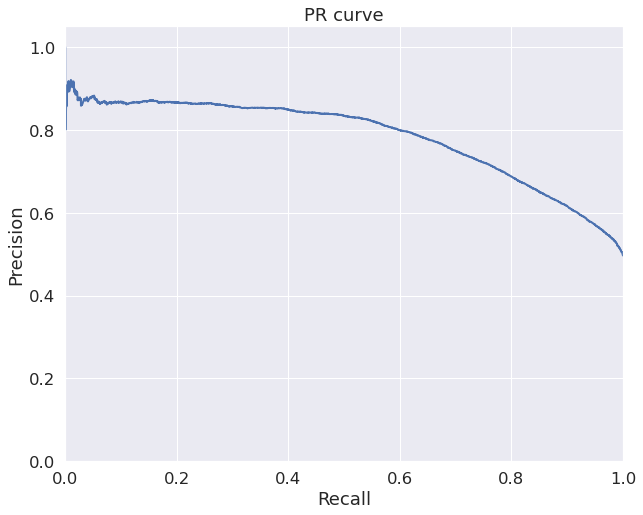

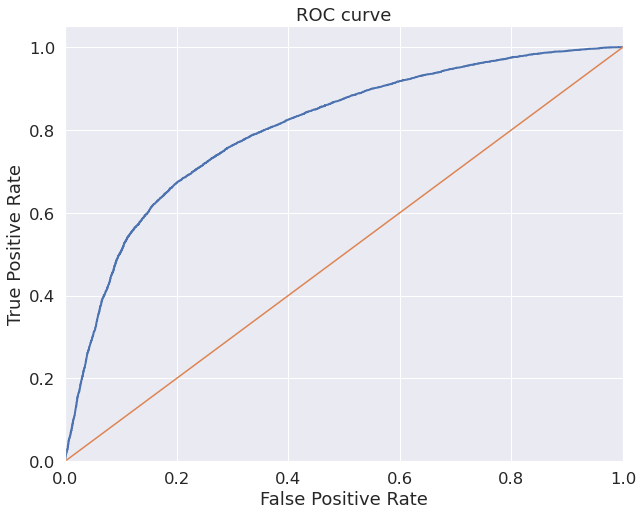

In [12]:
table = table_metrics(list_model, name_model, data)

In [10]:
y_train.value_counts()

1    26299
0    26201
Name: cardio, dtype: int64

In [11]:
y_test.value_counts()

0    8820
1    8680
Name: cardio, dtype: int64

Из трех моделей (не настроенных) самой лучшей оказалась модель градиентного бустинга (практически по всем метрикам)

In [13]:
table

,CV-score,Precision,Recall,Best Treshold,F-score,AUPRC,AUROC
Logistic Regression,0.786675,0.647431,0.837558,0.386937,0.730323,0.763174,0.784035
Random Forest,0.774055,0.634911,0.833065,0.330000,0.720614,0.753163,0.771474
Gradient Boosting,0.802366,0.697848,0.788134,0.394947,0.740248,0.783810,0.802616


Даже несмотря на отсутствие дисбалланса в таргете PR-curve ниже ROC-curve и, судя по F-score лучше отображает полезность модели. При увеличении дисбалланса классов эта разница будет увеличиваться, т.к. в ROC при вычислении FPR используются TN, что в свою очередь ведет к очень большому влиянию на метрику (модно даже поставить наивный классификатор на негативный класс и метрика будет высокой). поэтому при дисбаллансе классов лучше использовать PR-curve, площадь которой примерно равна среднему значению precision при построении этой кривой.

CV score in Logistic Regression is 0.7866517199865354+-0.0065273447816506375


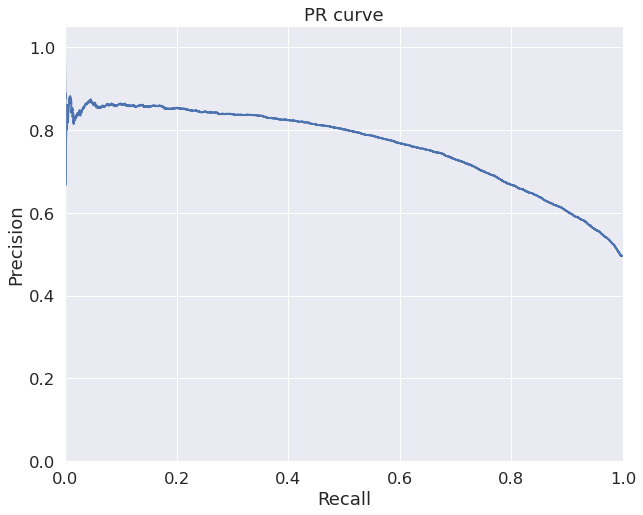

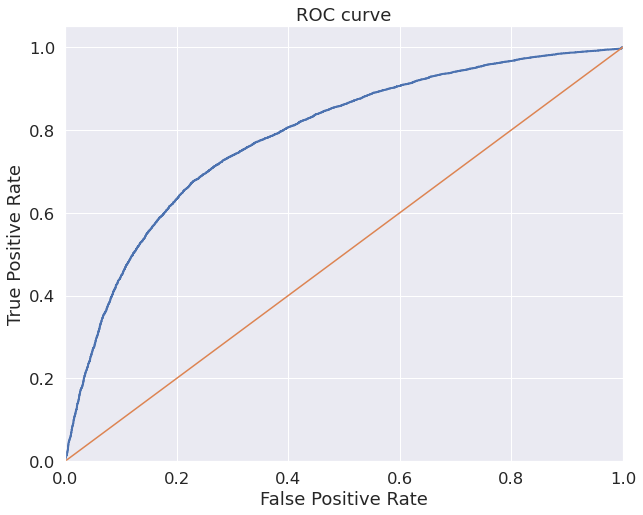

CV score in Random Forest is 0.7942795090583441+-0.005445013314990079


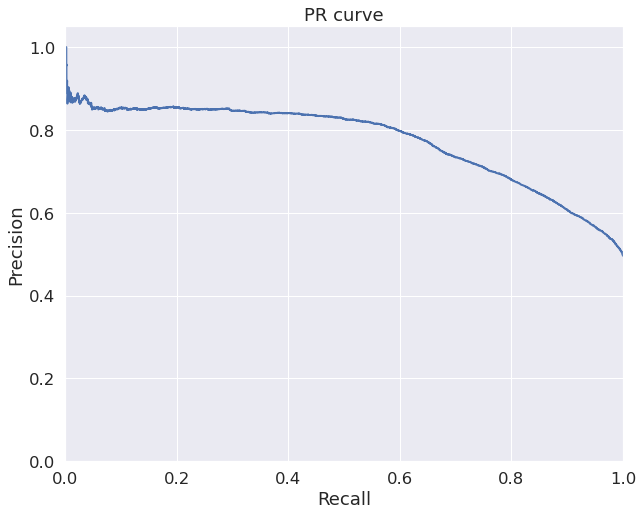

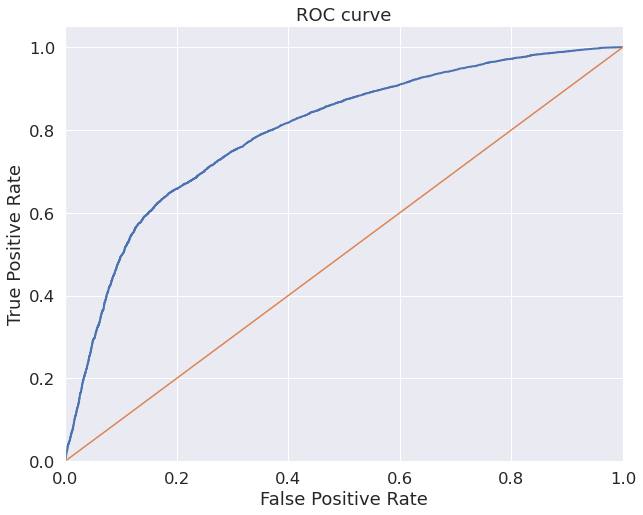

CV score in Gradient Boosting is 0.8023908914322133+-0.005839916842376104


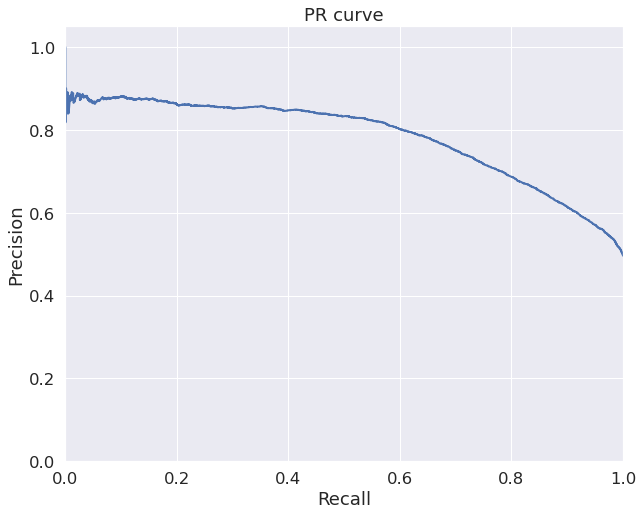

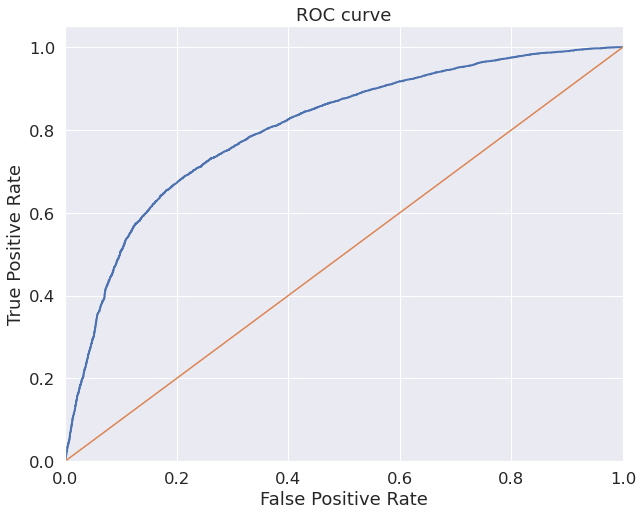

In [17]:
lr1 = LogisticRegression(random_state=12, solver='saga', penalty='elasticnet', C=0.7, l1_ratio=0.7, max_iter=1000)
rf1 = RandomForestClassifier(random_state=12, n_estimators=70, max_depth=5, n_jobs=-1, min_samples_leaf=10)
gb1 = GradientBoostingClassifier(random_state=12, n_estimators=70, max_depth=5)
list_model1 = [lr1, rf1, gb1]
table1 = table_metrics(list_model1, name_model, data)

In [18]:
table1

,CV-score,Precision,Recall,Best Treshold,F-score,AUPRC,AUROC
Logistic Regression,0.786652,0.646986,0.838249,0.386649,0.730302,0.763136,0.784013
Random Forest,0.794280,0.662366,0.828111,0.377814,0.736023,0.774773,0.795462
Gradient Boosting,0.802391,0.668679,0.829608,0.356366,0.740501,0.784162,0.802836


дополнительная настройка моделей большого результата не дала - значит для улучшения показателей уже нужно заниматься генерацией и отбором фичей 